# Final Project - Modeling Complex Systems

### Roy Madpis (319091526) And Michael Kobaivanov (206814485)

Drowing networkx graphs:
https://networkx.org/documentation/stable/reference/drawing.html

In [4]:
# pip install tqdm

In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
import math
from sklearn.model_selection import train_test_split

import networkx as nx
from tqdm import tqdm ### for cross bar of progress - red color
from tqdm.notebook import tqdm_notebook ### for cross bar of progress - Blue color

import scipy.integrate as spi #for the integrator
%matplotlib inline

In this assignment we'll simulate an imaginary evolving economy and use that simulation to study the wealth distribution within that economy and the effect of an individual's behavior on that individual's wealth.

The assignment is multifaceted in the sense that it requires skills in several areas:
+ learning new topics
+ problem-solving
+ and programming.


You were hired to advise the government of Zubawewe – a tiny tribenation that has just received its independence from Britain. The new government would like to establish a free economy, yet exercise some level of control over it, in an effort to avoid formation of large disparities and inequalities within its population and, as importantly, attempt to prevent poverty.

Some ideas regarding laws that need to be applied towards that end have been considered. **Your mission is to test the
long-term effect of these laws (rules), via simulation, and advise the government regarding the repercussions of their application**.

+ As part of the process of forming a new economy in the state, a new currency will be created and the government wishes to **hand out an equal amount of the new currency to all its current citizens**.

+ Moreover, it also wishes to grant a **fixed amount to each newborn child** (as long as both parents are citizens).


The ideas the government wishes to test in are detailed below. 


### The required simulation has two main components:
1. a growing/changing network, where each **node** represents an **agent** (person) and the **edges** connected to a node **represent this agent's** connections

2. A system of inter-agent wealth transactions wherein agents transact some of their wealth. 



Each node has several characteristics (traits), as detailed below.

Three of these traits need to be drawn from random distributions (which are based on behaviors observed in surveys of the Zubawewean population).

For each node ("individual"), you should keep track of the parameters characterizing that node.

The parameters include:
1. **saving-propensity $\sigma_p$**:
This value represents the agent's **inclination to save** and is randomly drawn, for each node, from a
beta(2, 10.7) distribution, shifted by 0.01, thereby forcing a minimum saving requirement, and capped at 0.7.
i.e.: $𝑚𝑖𝑛(0.01 + 𝑛𝑝.𝑟𝑎𝑛𝑑𝑜𝑚.𝑏𝑒𝑡𝑎(2, 10.7), 0.7).$

2. **Social-propensity $\phi$:**
This value represents the agent's **social inclination** (inclination towards connecting with other agents) a
randomly drawn standard-Normal distributed value. (Thus, the average agent social propensity is 0) 


3. **Business-propensity** $\beta$ :**
This value represents the **agent's business inclination** (or willingness to take risks) and is randomly drawn, for each node, from a lognorml distribution, using the following formula:
$$𝑚𝑖𝑛((𝑛𝑝.𝑟𝑎𝑛𝑑𝑜𝑚.𝑙𝑜𝑔𝑛𝑜𝑟𝑚𝑎𝑙(𝑚𝑒𝑎𝑛 = 3.4, 𝑠𝑖𝑔𝑚𝑎 = .55) + 1.4)/350, 0.5)$$

4. **Birth**:
A **timestamp** of **when the node was created**

5. **Wealth 𝑤:**
Initially, **at "birth", set to 100**. (This is the amount the government intends to grant each existing citizen as well as
each newborn.) 



The simulation should be run for **35,500 timesteps**. Throughout the run, two processes take place:
1. Network growth/alteration,
2. Inter-agent wealth transactions,

### Initial network:
Initially, the network is a 200-node E-R graph with 𝑝 = 0.15 , ie, each
existing node is connected to an average of 30 nodes. The internode
connections (edges) are to be randomly generated. This initial state
represents the current population of Zimbawewe 


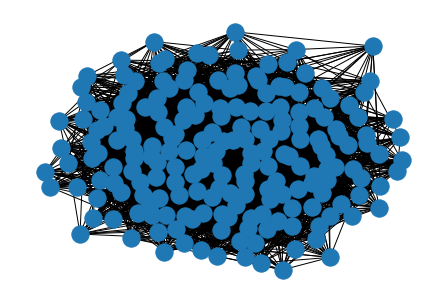

In [6]:
n = 200 #number of nodes
p = 0.15 #Probability for edge creation.
seed = 1998 #None if don't want seed
ER_graph = nx.erdos_renyi_graph(n, p, seed=seed, directed=False)

## add age attribute to the graph
nx.set_node_attributes(ER_graph, values = 0, name="age")

nx.draw(ER_graph)

### Network dynamics:
Once the initial network is set up, the **dynamics of the system** are characterized by **three processes** that take place at various times, namely:
+ **node deletion**
+ **node generation**
+ **connections (edges) alterations**. 


1. **Nodes get deleted (die) when they reach an "age" of 𝑡 = 18,250**.
At that point, their wealth is equally distributed between all
of their immediate (𝑘 = 1) connections.
NOTE: removal of "deceased" nodes should be done prior to
addition of new nodes, i.e., the calculation of the number of
nodes that need to be added at time t should be done after the
removal of deceased nodes. 



Each newly generated node (i.e. a node added after the initial
network is set) is initially connected to 2 randomly selected
interconnected nodes ("parents") and to all of the immediate
(𝑘 = 1) connections of those two nodes. Note that the 2 parents
must be interconnected, i.e. 1st degree neighbors. 

In [7]:
### Code for statistics evaluation
### function to get a data framewith all the nodes and their attributes + df with statistics

def statistics_simulation(time_stamp_index, graph):
    
    df = pd.DataFrame.from_dict(graph.nodes.keys())
    df["age"] = pd.DataFrame.from_dict(nx.get_node_attributes(graph, attribute_age_name).values())
    df["wealth"] = pd.DataFrame.from_dict(nx.get_node_attributes(graph, attribute_wealth_name).values())
    df["sigma_p"] = pd.DataFrame.from_dict(nx.get_node_attributes(graph, attribute_sigma_p_name).values())
    df["beta"] = pd.DataFrame.from_dict(nx.get_node_attributes(graph, attribute_beta_name).values())
    df["phi"] = pd.DataFrame.from_dict(nx.get_node_attributes(graph, attribute_phi_name).values())
    df.rename(columns = {0:'node_index'}, inplace = True)
    
    df_nodes = df
    
    t = time_stamp_index
    
    index_of_statistics = "Statistics for time stamp " + str(t)

    #mean wealth
    mean_wealth = np.round(np.mean(df.wealth),3)

    #median wealth
    median_wealth = np.round(np.median(df.wealth),3)

    # min(wealth), i.e., agent with the smallest wealth
    node_with_smallest_wealth = df[df.wealth == df.wealth.min()].head(1)
    node_with_smallest_wealth = np.round(node_with_smallest_wealth,3).add_suffix("_min_wealth").transpose()
    node_with_smallest_wealth.rename(columns = {node_with_smallest_wealth.columns[0]:index_of_statistics}, inplace = True)

    #max(wealth), i.e., the agent with the highest wealth
    node_with_max_wealth = df[df.wealth == df.wealth.max()].head(1)
    node_with_max_wealth = np.round(node_with_max_wealth,3).add_suffix("_max_wealth").transpose()
    node_with_max_wealth.rename(columns = {node_with_max_wealth.columns[0]:index_of_statistics}, inplace = True)

    #percent population below the poverty line (defining the poverty line as 35) 
    population_below_povery_line = df[df.wealth < poverty_line].shape[0]
    percent_population_below_poverty_line = np.round(population_below_povery_line/df.shape[0],3)

    df_statistics = pd.DataFrame(data = [[mean_wealth, median_wealth, percent_population_below_poverty_line, treasury]],
                                 columns = ["mean wealth", "median wealth", "Percent Population below poverty line", "treasury Capital"],
                                 index=[index_of_statistics])

    df_statistics = df_statistics.transpose()
    df_statistics_new = pd.concat([df_statistics, node_with_smallest_wealth], axis = 0)
    df_statistics_new = pd.concat([df_statistics_new, node_with_max_wealth], axis = 0)

    return(df_nodes, df_statistics_new)

In [5]:
### The following function gets as input a data frame (df) with all the nodes and their attributes,
#this is in fact the output of the function `statistics_simulation`

def graphs_simulation(df):

    #### plot wealth distribution
    plt.figure(figsize=(6,5))
    hist_sns = sns.histplot(data = df, x = "wealth")#.set(title='Wealth Distribution')
    hist_sns.axes.set_title("Wealth Distribution",fontsize=20) # wealth distribution
    ############################################################################################

    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(13,13))
    ### wealth vs sigma
    regplot_wealth_sigma = sns.regplot(x="sigma_p", y="wealth", data = df, ax=axs[0,0]) #reg plot of wealth vs sigma
    regplot_wealth_sigma.axes.set_title("Wealth vs sigma",fontsize=20)#line plot of wealth vs sigma

    sns.lineplot(x = "sigma_p", y = "wealth", data = df, ax=axs[0,1])

    ### wealth vs beta
    regplot_wealth_beta = sns.regplot(x="beta", y="wealth", data = df, ax=axs[1,0]) #reg plot of wealth vs beta
    regplot_wealth_beta.axes.set_title("Wealth vs beta",fontsize=20)  #line plot of wealth vs beta

    sns.lineplot(x = "beta", y = "wealth", data = df, ax=axs[1,1])

    ### Wealth vs phi
    regplot_wealth_phi = sns.regplot(x="phi", y="wealth", data = df, ax=axs[2,0]) #.set(title='Wealth vs Phi - line plot with regression line')
    regplot_wealth_phi.axes.set_title("Wealth vs phi",fontsize=20)  #line plot of wealth vs phi
    sns.lineplot(x = "phi", y = "wealth", data = df, ax=axs[2,1]) #.set(title='Wealth vs Phi - scatter plot with regression line')

    ### space between each subplot
    plt.subplots_adjust(hspace = 0.3)

    plt.show()
    print("---------------------------------------- ********************************* ----------------------------------------")



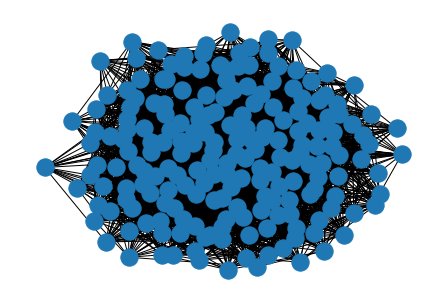

In [10]:
n = 200
p = 0.15 #Probability for edge creation.
seed = 1998
ER_graph = nx.erdos_renyi_graph(n, p, seed=seed, directed=False)
nx.draw(ER_graph)

attribute_age_name = "age"
attribute_wealth_name = "wealth"
attribute_sigma_p_name = "sigma_p"
attribute_beta_name = "beta"
attribute_phi_name = "phi"


## add age attribute to the nodes in the graph
start_age_value = 0
nx.set_node_attributes(ER_graph, values = start_age_value, name= attribute_age_name) #age
##add wealth value to the nodes in the graph
start_wealth_value = 100
nx.set_node_attributes(ER_graph, values = start_wealth_value, name= attribute_wealth_name) #wealth

## add sigma_p attribute to the nodes in the graph
#start_sigma_p_value = 0
#nx.set_node_attributes(ER_graph, values = start_sigma_p_value, name= attribute_sigma_p_name) #sigma p

    
## add beta attribute to the nodes in the graph
#start_beta_value = 0
#nx.set_node_attributes(ER_graph, values = start_beta_value, name= attribute_beta_name) #beta

## add phi attribute to the nodes in the graph
#start_phi_value = 0
#nx.set_node_attributes(ER_graph, values = start_phi_value, name= attribute_phi_name) #phi


#ER_graph.nodes[2]["age"] = 15
#ER_graph.nodes[4]["age"] = 17
#ER_graph.nodes[7]["age"] = 19
#ER_graph.nodes[9]["age"] = 4
#ER_graph.nodes[1]["age"] = 3

graph = ER_graph

# set random attribute values
for node in graph.nodes:
    sigma_p_value = min(0.01 + np.random.beta(2,10.7), 0.7) #random sigma p value - – this value represents the agent's
    #inclination to save - forcing a minimum saving requirement, and capped at 0.7. 
    
    phi_value = np.random.normal(0, 1, 1)  #random phi value - this value represents the agent's social inclination (inclination towards connecting with other agents)
    
    #this value represents the agent's business inclination (or willingness to take risks) 
    beta_value = min((np.random.lognormal(mean = 3.4, sigma = 0.55) + 1.4)/350, 0.5)
    
    ## add sigma_p attribute to the nodes in the graph
    graph.nodes[node][attribute_sigma_p_name] = sigma_p_value
    
    ## add phi attribute to the nodes in the graph
    graph.nodes[node][attribute_phi_name] = phi_value

    ## add beta attribute to the nodes in the graph
    graph.nodes[node][attribute_beta_name] = beta_value
    
    


In [11]:
#nodes_i = n #the number of initial nodes
nodes_with_neighbors = [] #this list will contain all the nodes with at least one neighbor
for node in graph.nodes:
    
    #the neighbors of node i
    neighbors_node_i = [n for n in graph.neighbors(node)]
    num_of_neighbors = len(neighbors_node_i)

    if num_of_neighbors >= 2:
        nodes_with_neighbors.append(node)


In [12]:
#nodes_f = 41000  #limiting factor on the total number of nodes
#N_t = int(n + (nodes_f - n)*((1)/(1+math.exp(-((t/3500)-1)))))#the required amount of nodes in time t
#need_to_add_nodes = max(N_t - len(graph.nodes),0)
need_to_add_nodes = 10
attribute_wealth_name = "wealth"
attribute_age_name = "age"

### Add more nodes to the graph:
for i in range(need_to_add_nodes):
    random_chosen_neighbor = random.choice(list(graph.nodes)) #chose random node - A
    neighbors_node_i = [n for n in graph.neighbors(random_chosen_neighbor)] #find the neighbors of node A
    #if neighbors_node_i > 0:
    random_neighbor_of_neighbor_i = random.choice(neighbors_node_i) #chose one of the neighbors of node A in random - node B
    neighbor_of_random__neighbor_of_neighbor_i =  [n for n in graph.neighbors(random_neighbor_of_neighbor_i)] #find node B neighbors
    all_first_degree_neighbors_of_parents = [random_chosen_neighbor] + neighbors_node_i + [random_neighbor_of_neighbor_i] + neighbor_of_random__neighbor_of_neighbor_i
    all_first_degree_neighbors_of_parents = list(set(all_first_degree_neighbors_of_parents)) #take only unique values

    last_node_index = graph.number_of_nodes() 
    graph.add_node(last_node_index)
    
    ###set age attribute and wealth attribute:
    graph.nodes[last_node_index][attribute_age_name] = start_age_value #age
    graph.nodes[last_node_index][attribute_wealth_name] = start_wealth_value #wealth
    
    for node_to_connect in all_first_degree_neighbors_of_parents:
        #print(node_to_connect)
        graph.add_edge(last_node_index, node_to_connect)
        
    #neighbor_of_random__neighbor_of_neighbor_i =  [n for n in graph.neighbors(random_neighbor_of_neighbor_i)] #find node B neighbors
#

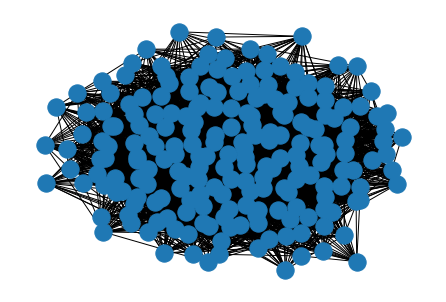

In [13]:
nx.draw(graph)

In [14]:
random_neighbor_of_neighbor_i = random.choice(neighbors_node_i) #chose one of the neighbors of node A in random - node B
random_neighbor_of_neighbor_i

36

In [15]:
graph.add_node(last_node_index)
for node_to_connect in all_first_degree_neighbors_of_parents:
    #print(node_to_connect)
    graph.add_edge(last_node_index, node_to_connect)


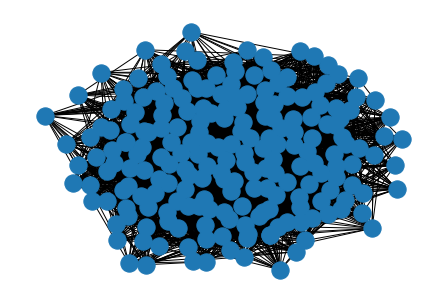

In [16]:
nx.draw(graph)

In [17]:
N_t = int(n + (nodes_f - n)*((1)/(1+math.exp(-((t/3500)-1)))))#the required amount of nodes in time t
need_to_add_nodes = max(N_t - len(graph.nodes),0)
need_to_add_nodes = 10
attribute_wealth_name = "wealth"

### Add more nodes to the graph:
for i in range(need_to_add_nodes):
    random_chosen_neighbor = random.choice(list(graph.nodes)) #chose random node - A
    neighbors_node_i = [n for n in graph.neighbors(random_chosen_neighbor)] #find the neighbors of node A
    if len(neighbors_node_i) > 0: #if node A doesn't have neighbors
        random_neighbor_of_neighbor_i = random.choice(neighbors_node_i) #chose one of the neighbors of node A in random - node B
    else:
        random_neighbor_of_neighbor_i = []

    neighbor_of_random__neighbor_of_neighbor_i =  [n for n in graph.neighbors(random_neighbor_of_neighbor_i)] #find node B neighbors
    #this is a list with all the neighbors of the "parent nodes" meaning all the neighors of A and B
    all_first_degree_neighbors_of_parents = [random_chosen_neighbor] + neighbors_node_i + [random_neighbor_of_neighbor_i] + neighbor_of_random__neighbor_of_neighbor_i
    all_first_degree_neighbors_of_parents = list(set(all_first_degree_neighbors_of_parents)) #take only unique values

    last_node_index = graph.number_of_nodes() 

    new_born_node = nx.Graph([(last_node_index, random_chosen_neighbor), (last_node_index, random_neighbor_of_neighbor_i)]) #
    #generate a node (C) which is the child of A and B. C is connected to A,B, and all the neighbors of A and B.

    #graph.add_node(new_born_node)

NameError: name 'nodes_f' is not defined

## Running the Zimbabuwe Simulation 

The dir log_simulation already exist
Finish pre-simulation preperation in 0.02 Seconds 



  0%|          | 0/35500 [00:00<?, ?it/s]

Time stamp number:  1
Average time in each time-stamp:  0 Seconds
Number of nodes:  Total Number of nodes: 201
Number of edges:  Total Number of edges: 3103


,Statistics for time stamp 0
mean wealth,100.000
median wealth,100.000
Percent Population below poverty line,0.000
treasury Capital,0.000
node_index_min_wealth,0.000
age_min_wealth,1.000
wealth_min_wealth,100.000
sigma_p_min_wealth,0.139
beta_min_wealth,0.138
phi_min_wealth,-0.037


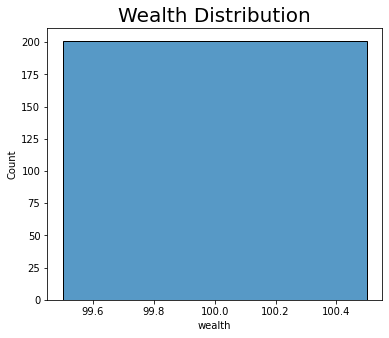

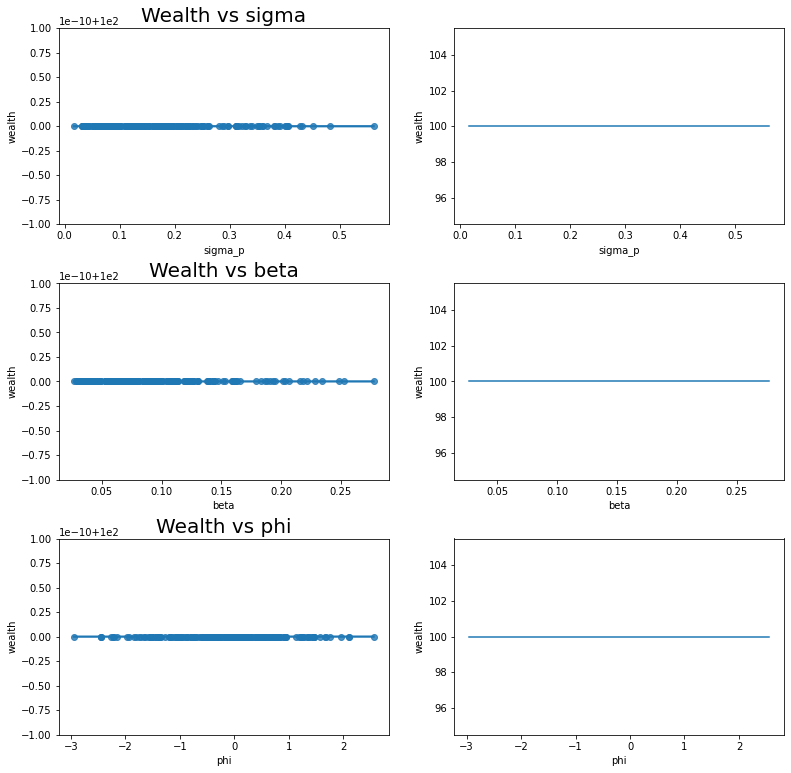

---------------------------------------- ********************************* ----------------------------------------
Time stamp number:  5001
Average time in each time-stamp:  0.004 Seconds
Number of nodes:  Total Number of nodes: 207
Number of edges:  Total Number of edges: 3137


,Statistics for time stamp 5000
mean wealth,100.000
median wealth,97.764
Percent Population below poverty line,0.000
treasury Capital,0.000
node_index_min_wealth,138.000
age_min_wealth,5001.000
wealth_min_wealth,56.177
sigma_p_min_wealth,0.127
beta_min_wealth,0.229
phi_min_wealth,0.075


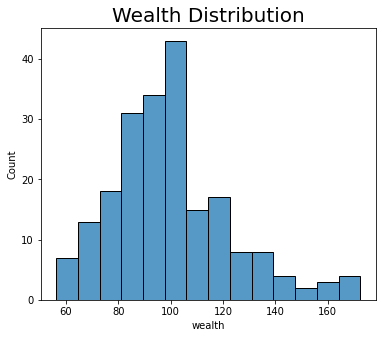

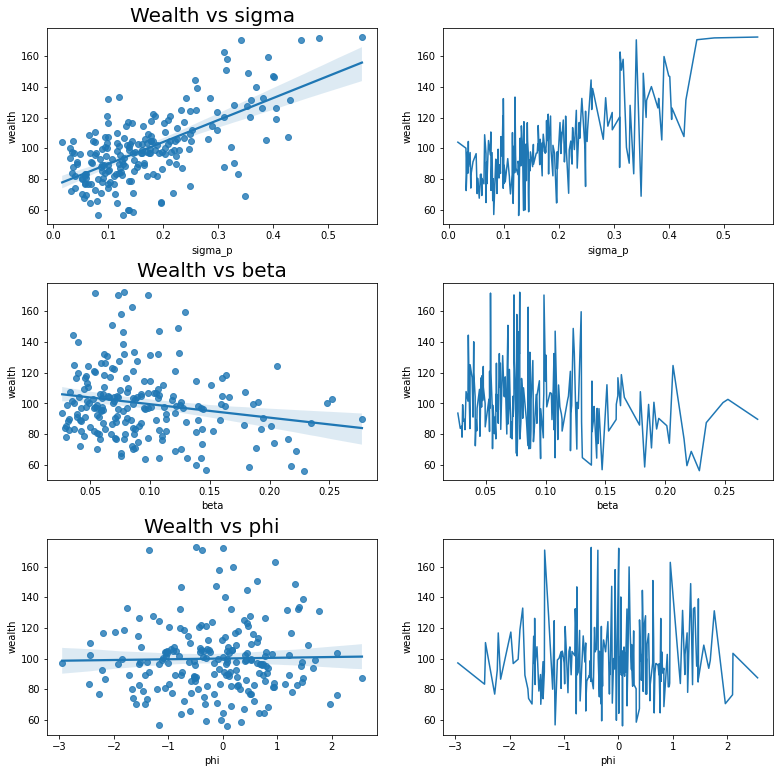

---------------------------------------- ********************************* ----------------------------------------
Time stamp number:  10001
Average time in each time-stamp:  0.002 Seconds
Number of nodes:  Total Number of nodes: 232
Number of edges:  Total Number of edges: 4684


,Statistics for time stamp 10000
mean wealth,100.000
median wealth,96.048
Percent Population below poverty line,0.000
treasury Capital,0.000
node_index_min_wealth,148.000
age_min_wealth,10001.000
wealth_min_wealth,37.345
sigma_p_min_wealth,0.036
beta_min_wealth,0.130
phi_min_wealth,-0.533


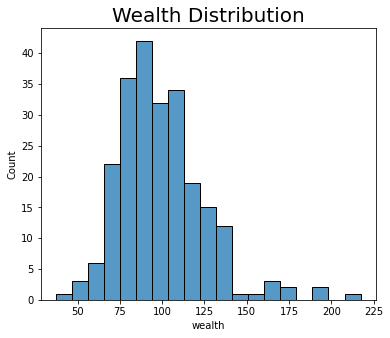

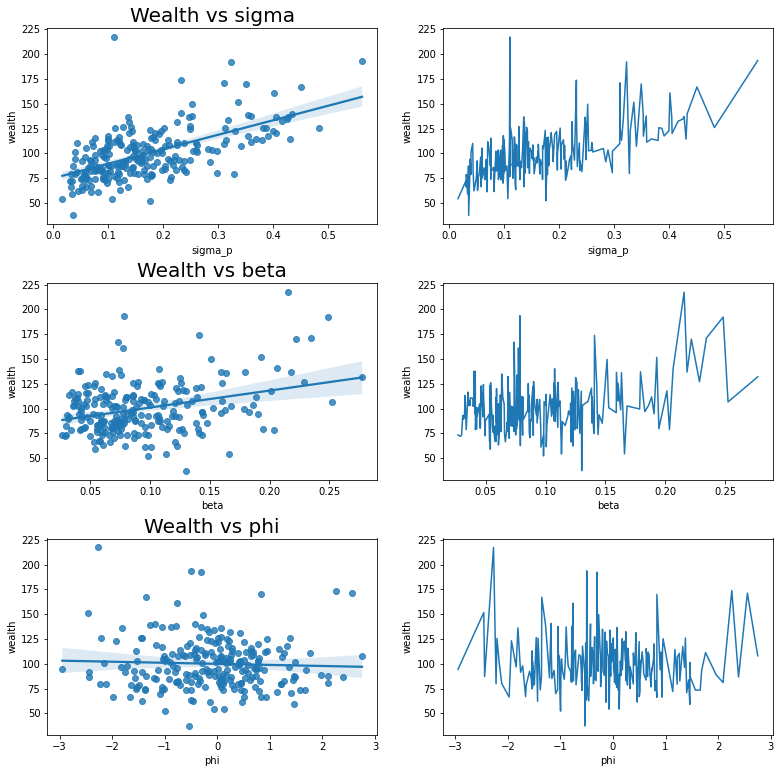

---------------------------------------- ********************************* ----------------------------------------
Time stamp number:  15001
Average time in each time-stamp:  0.003 Seconds
Number of nodes:  Total Number of nodes: 334
Number of edges:  Total Number of edges: 19188


,Statistics for time stamp 15000
mean wealth,100.000
median wealth,97.287
Percent Population below poverty line,0.003
treasury Capital,0.000
node_index_min_wealth,282.000
age_min_wealth,1684.000
wealth_min_wealth,30.985
sigma_p_min_wealth,0.050
beta_min_wealth,0.209
phi_min_wealth,-0.493


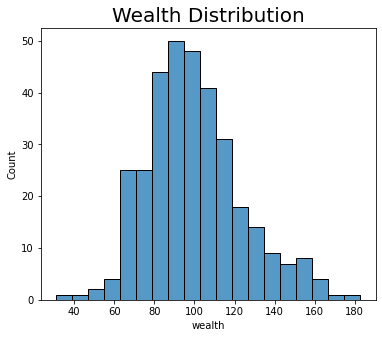

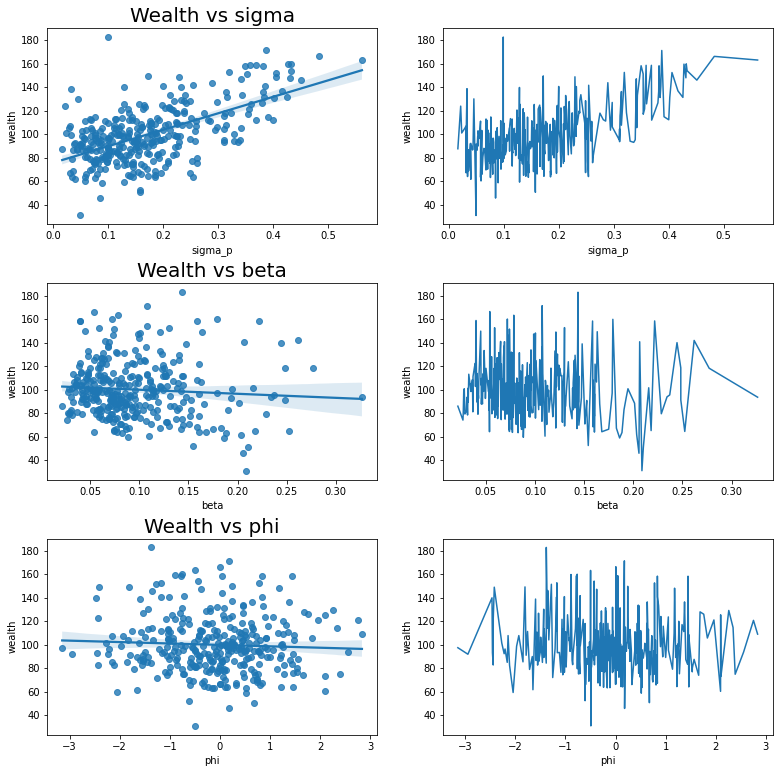

---------------------------------------- ********************************* ----------------------------------------
Time stamp number:  20001
Average time in each time-stamp:  0.004 Seconds
Number of nodes:  Total Number of nodes: 753
Number of edges:  Total Number of edges: 274941


,Statistics for time stamp 20000
mean wealth,126.650000
median wealth,123.507000
Percent Population below poverty line,0.000000
treasury Capital,222.493184
node_index_min_wealth,570.000000
age_min_wealth,1751.000000
wealth_min_wealth,45.962000
sigma_p_min_wealth,0.206000
beta_min_wealth,0.280000
phi_min_wealth,0.318000


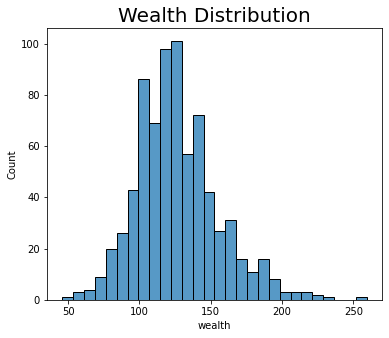

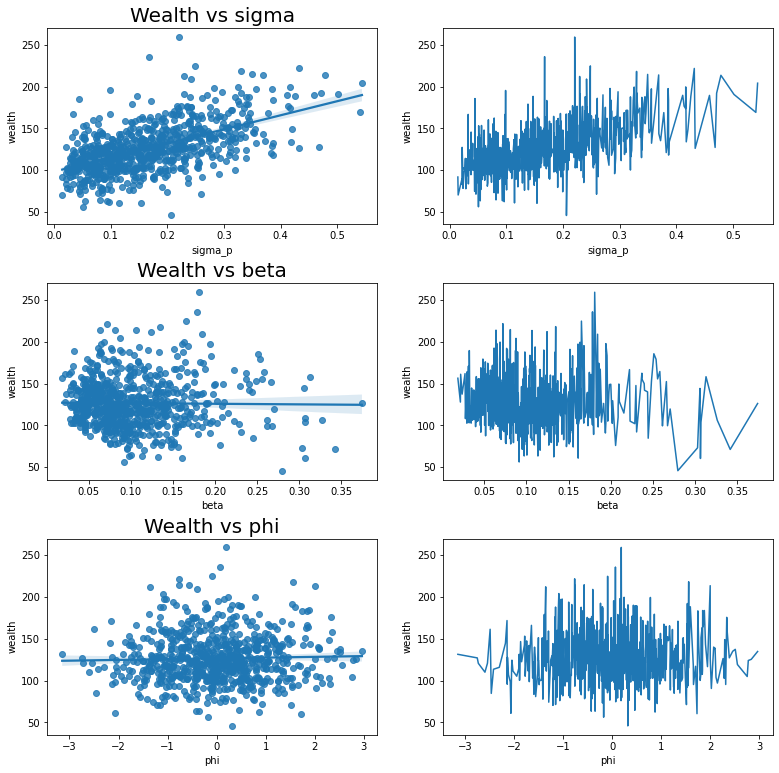

---------------------------------------- ********************************* ----------------------------------------
Time stamp number:  25001
Average time in each time-stamp:  0.016 Seconds
Number of nodes:  Total Number of nodes: 2415
Number of edges:  Total Number of edges: 2905134


,Statistics for time stamp 25000
mean wealth,108.682000
median wealth,105.628000
Percent Population below poverty line,0.000000
treasury Capital,222.493184
node_index_min_wealth,452.000000
age_min_wealth,7768.000000
wealth_min_wealth,42.752000
sigma_p_min_wealth,0.154000
beta_min_wealth,0.307000
phi_min_wealth,1.729000


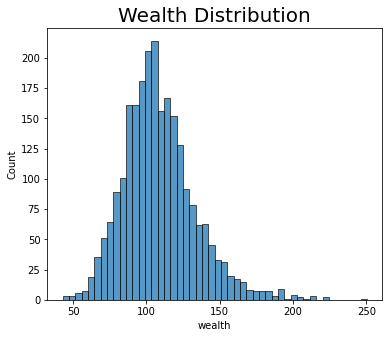

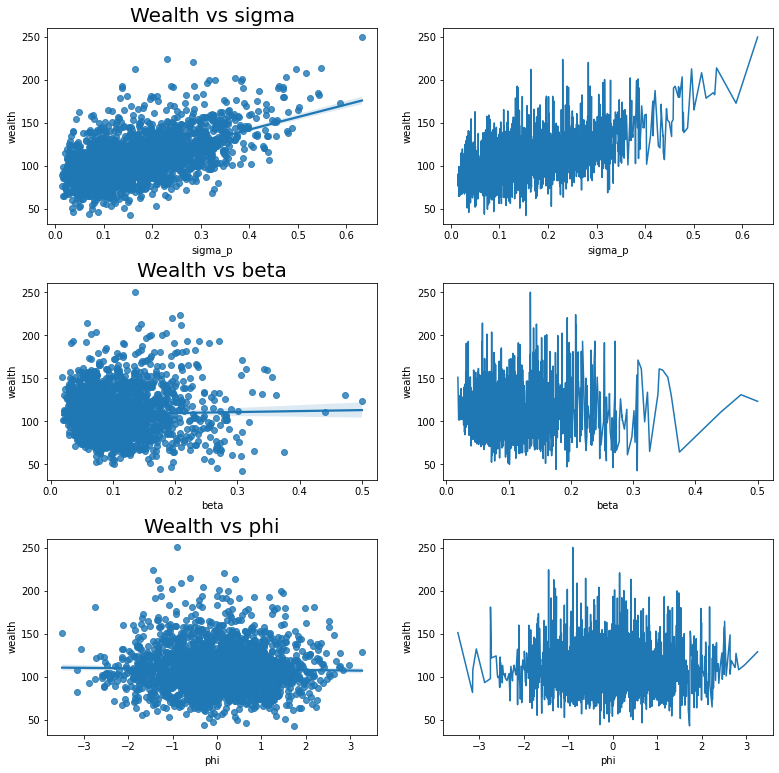

---------------------------------------- ********************************* ----------------------------------------
Time stamp number:  30001
Average time in each time-stamp:  0.112 Seconds
Number of nodes:  Total Number of nodes: 8087
Number of edges:  Total Number of edges: 32679026


,Statistics for time stamp 30000
mean wealth,103.100000
median wealth,100.282000
Percent Population below poverty line,0.000000
treasury Capital,222.493184
node_index_min_wealth,6371.000000
age_min_wealth,1197.000000
wealth_min_wealth,27.019000
sigma_p_min_wealth,0.147000
beta_min_wealth,0.361000
phi_min_wealth,-0.623000


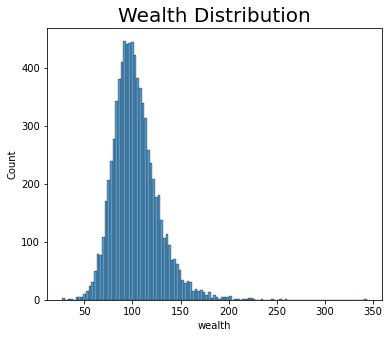

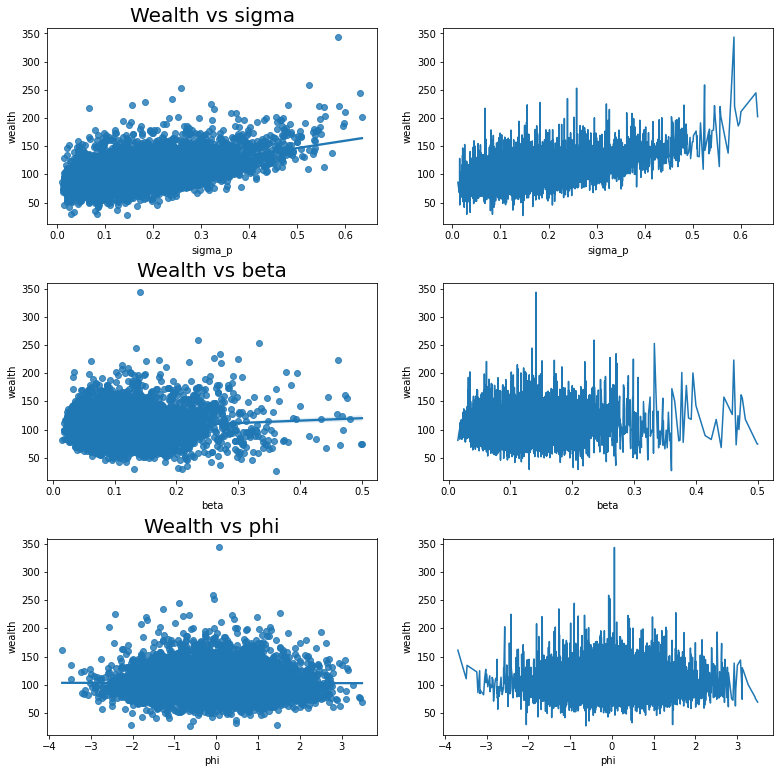

---------------------------------------- ********************************* ----------------------------------------


: 

: 

In [8]:
### Varibales to following time 
start_time = time.time()
list_times_in_each_time_stamp = []
restart_list_times_in_each_time_stamp = True #if this is true then the function will restart the list of list_times_in_each_time_stamp
# in this way, in each k time-stamps when the function prints the statistics table + graph and dispalys the average time
#in each time stamp, it will restart the counting and thus in each such print, lets say every 1000 time-stamps,
#we wil get the average time in each time stamp only in the last 1000 time stamps

########################################## Simulation
simulation_length = 35500 #35500
die_age = 18250 #18250
nodes_f = 41000 #41000  #limiting factor on the total number of nodes
#graph = ER_graph
attribute_age_name = "age"
attribute_birth_name = "birth"
attribute_wealth_name = "wealth"
attribute_sigma_p_name = "sigma_p"
attribute_beta_name = "beta"
attribute_phi_name = "phi"
ages_to_modify_connections = list(range(0, simulation_length+1, 500))[1:]

poverty_line = 35

verbose_check=  False
print_statistics_and_graphs = True
treasury = 0
print_graph_in_each_k_steps = 5000 #1000

#create log dir for the simulation
### in the log dir we would like to create a text file and insert to it the progration status
log_dir_name = "log_simulation"
log_file_name = "log_simulation.txt"
try:
    os.mkdir(log_dir_name)
    print("creating log directory", log_dir_name, "to store the log of the simulation")
except:
    print("The dir", log_dir_name ,"already exist")

path_for_log_file_name = os.path.join(log_dir_name, log_file_name)

from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S (Date: %d.%m.%y)")
current_time = "Current Time: " + current_time + "   *****************************************   "

with open(path_for_log_file_name, 'a') as f:
    f.write(current_time + '\n\n')

################################################## Initiate the settings    
n = 200
p = 0.15 #Probability for edge creation.
seed = 1998
graph = nx.erdos_renyi_graph(n, p, seed=seed, directed=False)

## add age attribute to the nodes in the graph
start_age_value = 0
nx.set_node_attributes(graph, values = start_age_value, name= attribute_age_name) #age
##add wealth value to the nodes in the graph
start_wealth_value = 100
nx.set_node_attributes(graph, values = start_wealth_value, name= attribute_wealth_name) #wealth

# set random attribute values
for node in graph.nodes:
    sigma_p_value = min(0.01 + np.random.beta(2,10.7), 0.7) #random sigma p value - – this value represents the agent's
    #inclination to save - forcing a minimum saving requirement, and capped at 0.7. 
    
    phi_value = np.random.normal(0, 1, 1)  #random phi value - this value represents the agent's social inclination (inclination towards connecting with other agents)
    
    #this value represents the agent's business inclination (or willingness to take risks) 
    beta_value = min((np.random.lognormal(mean = 3.4, sigma = 0.55) + 1.4)/350, 0.5)
    
    ## add sigma_p attribute to the nodes in the graph
    graph.nodes[node][attribute_sigma_p_name] = sigma_p_value
    
    ## add phi attribute to the nodes in the graph
    graph.nodes[node][attribute_phi_name] = phi_value

    ## add beta attribute to the nodes in the graph
    graph.nodes[node][attribute_beta_name] = beta_value

    ## add birth timestamp
    graph.nodes[node][attribute_birth_name] = 0
    
    
last_node_index = max(list(graph.nodes))  #store the last index of the node in the graph - for creating mpre nodes later

print("Finish pre-simulation preperation in", round(time.time() - start_time, 3) , "Seconds \n")
####################################### THE For loop - running the simulation ######################################
for t in tqdm_notebook(range(simulation_length)):
    start_time_stamp_time = time.time()

    #print("time = ", t+1)
    #update the age of each node - add 1 to it
    nodes_to_remove = []
    
    if verbose_check:
        print("------------------------------------------------------------------")
        #print(graph.nodes)
        #print("need_to_add_nodes:", need_to_add_nodes)
        print("Number of nodes:",len(graph.nodes))
        print("Number of edges:",len(graph.edges))
        print(last_node_index)
    
    for node in graph.nodes:
        ##### update age attribute
        graph.nodes[node][attribute_age_name] = graph.nodes[node][attribute_age_name] + 1
        
        ### if node reached die age - add it to list of nodes to remove
        if graph.nodes[node][attribute_age_name] >= die_age:
            nodes_to_remove.append(node)
        
        ### if the age of the node is 500, 1000, 1500, etc
        if graph.nodes[node][attribute_age_name] in ages_to_modify_connections :
            if verbose_check: print("handling edges")
            formula_for_edges = int(np.round(np.random.normal(loc = graph.nodes[node][attribute_phi_name]),0))

            if formula_for_edges < 0 : #then randomly remove edges
                nodes_neighbors = list(graph.neighbors(node))
                if len(nodes_neighbors) > 2:
                    #if you are asked to remove more edges than the amount of existing edgesm than just remove all of them
                    numer_of_edges_to_remove = min(np.abs(formula_for_edges),len(nodes_neighbors)-2) #k
                    
                    ### now we need to randomly select K EDGES TO REMOVE, K = |formula_for_edges|
                    remove_edges_from_the_following_nodes = random.sample(nodes_neighbors, numer_of_edges_to_remove)

                    ### removing the edges:
                    if len(remove_edges_from_the_following_nodes) > 0:
                        for edge_to_remove in remove_edges_from_the_following_nodes:
                            graph.remove_edge(node, edge_to_remove)

            else: #then add edges
                nodes_neighbors = list(graph.neighbors(node))
                ### now we need to randomly select K EDGES TO add from the ones that are not already connected, K = |formula_for_edges|
                not_1st_relatives_nodes = list(set(graph.nodes) - set(nodes_neighbors))
                numer_of_edges_to_add = min(formula_for_edges, len(not_1st_relatives_nodes))
                add_edges_from_the_following_nodes  = random.sample(not_1st_relatives_nodes, numer_of_edges_to_add)
            
                for edge_to_add in add_edges_from_the_following_nodes:
                    graph.add_edge(node, edge_to_add)
        
        #if verbose_check: print(graph.nodes[node]) 
        
    #remove nodes that reached die age, before removing them:
    # equally distribute their wealth
    for node_to_remove in nodes_to_remove:
        neighbors_of_node_i_that_die = list(graph.neighbors(node_to_remove)) #this list contains the neighbors of node i
        #that we want to split between them the wealth of node i that die
        if len(neighbors_of_node_i_that_die) > 0: #if there is at least one neighbor
            wealth_splitted = graph.nodes[node_to_remove][attribute_wealth_name]/len(neighbors_of_node_i_that_die)
            for neighbor_j_of_node_i_that_die in neighbors_of_node_i_that_die:
                graph.nodes[neighbor_j_of_node_i_that_die][attribute_wealth_name] += wealth_splitted
        else: #save the wealth to fund
            treasury += graph.nodes[node_to_remove][attribute_wealth_name]
        
        graph.remove_node(node_to_remove)
          
    #N_t = int(n + (nodes_f - n)*((1)/(1+math.exp(-((t/3500)-1)))))#the required amount of nodes in time t
    
    N_t = int(n + (nodes_f - n)/(1+math.exp(-((t/3500)-10)))) #the required amount of nodes in time t

    need_to_add_nodes = N_t - len(graph.nodes)
    
    if verbose_check: print(need_to_add_nodes)
        
    #need_to_add_nodes = 10
    ### Add more nodes to the graph:
    for i in range(need_to_add_nodes):
        last_node_index +=1
        random_chosen_neighbor = random.choice(list(graph.nodes)) #chose random node - A
        neighbors_node_i = list(graph.neighbors(random_chosen_neighbor)) #find the neighbors of node A
        counter_loops = 0
        while len(neighbors_node_i) < 1 and counter_loops <= 30: #as long as the number of neighbors of node A is 
            #less than 1, than we need to try to find another node with at least 1 neighbor, we will try this at max 20 times
            counter_loops +=1
            random_chosen_neighbor = random.choice(list(graph.nodes)) #chose random node - A
            neighbors_node_i = list(graph.neighbors(random_chosen_neighbor)) #find the neighbors of node A
        if len(neighbors_node_i) > 0:
            random_neighbor_of_neighbor_i = random.choice(neighbors_node_i) #chose one of the neighbors of node A in random - node B
            neighbor_of_random__neighbor_of_neighbor_i =  list(graph.neighbors(random_neighbor_of_neighbor_i)) #find node B neighbors
            all_first_degree_neighbors_of_parents = [random_chosen_neighbor] + neighbors_node_i + [random_neighbor_of_neighbor_i] + neighbor_of_random__neighbor_of_neighbor_i
            all_first_degree_neighbors_of_parents = list(set(all_first_degree_neighbors_of_parents)) #take only unique values
        
        graph.add_node(last_node_index)

        ###set age attribute, wealth attribute, sigma_p, beta and phi attributes:
        sigma_p_value = min(0.01 + np.random.beta(2,10.7), 0.7) #random sigma p value - – this value represents the agent's
        #inclination to save - forcing a minimum saving requirement, and capped at 0.7. 
        phi_value = np.random.normal(0, 1, 1)  #random phi value - this value represents the agent's social inclination (inclination towards connecting with other agents)
        #this value represents the agent's business inclination (or willingness to take risks) 
        beta_value = min((np.random.lognormal(mean = 3.4, sigma = 0.55) + 1.4)/350, 0.5)
        
        graph.nodes[last_node_index][attribute_age_name] = start_age_value #age
        graph.nodes[last_node_index][attribute_wealth_name] = start_wealth_value #wealth
        graph.nodes[last_node_index][attribute_sigma_p_name] = sigma_p_value #sigma p
        graph.nodes[last_node_index][attribute_beta_name] = beta_value #beta
        graph.nodes[last_node_index][attribute_phi_name] = phi_value #phi
        graph.nodes[last_node_index][attribute_birth_name] = t #birth

        if len(all_first_degree_neighbors_of_parents) >0:
            for node_to_connect in all_first_degree_neighbors_of_parents:
                #print(node_to_connect)
                graph.add_edge(last_node_index, node_to_connect)

    ###### TRANSACTIONS --> happen after all the updates and at each 3 time stampe: 3,6,9,12 ...
    if t%3==0 and t!=0:
        ### At each transaction time, we first divide the existing nodes into two equal-sized groups,
        #which we'll designate A and B. if the overall number of nodes at that time is odd,
        #one node should be randomly selected and removed from the transacting nodes
        num_of_nodes_in_transactions_group = int(math.floor(len(graph.nodes)/2))

        A_Payers ,B_receivers = train_test_split(np.asarray(graph.nodes),train_size=num_of_nodes_in_transactions_group, test_size = num_of_nodes_in_transactions_group, shuffle = True)

        ### sorting the two groups of nodes by the beta (decreasing)
        A_Payers = sorted(A_Payers, key=lambda n: -graph.nodes[n][attribute_beta_name])
        B_receivers = sorted(B_receivers, key=lambda n: -graph.nodes[n][attribute_beta_name])
        
        ### Performing transaction for every per of payer and reciever
        for payer_receiver_i in range(len(A_Payers)):
            A_payer_i = A_Payers[payer_receiver_i]
            B_receiver_i = B_receivers[payer_receiver_i]

            payer_wealth = graph.nodes[A_payer_i][attribute_wealth_name]
            payer_sigma = graph.nodes[A_payer_i][attribute_sigma_p_name]
            #beta
            payer_beta = graph.nodes[A_payer_i][attribute_beta_name]
            receiver_beta = graph.nodes[B_receiver_i][attribute_beta_name]
            mean_beta = (payer_beta  + receiver_beta)/2

            payment = payer_wealth * (1-payer_sigma) *(mean_beta*(max(np.random.beta(a=2, b=5, size=1),0.01)))
            payment = float(payment)
     
            
            if payer_wealth>=payment : #perform transaction as the payer has enough wealth for the transaction
                graph.nodes[A_payer_i][attribute_wealth_name] -=  payment
                graph.nodes[B_receiver_i][attribute_wealth_name] +=  payment

    
    if print_statistics_and_graphs and t%print_graph_in_each_k_steps == 0 or t==simulation_length-1: #and t!=0:
        ### function to get a data framewith all the nodes and their attributes + df with statistics

        df_nodes, df_statistics = statistics_simulation(time_stamp_index = t, graph = graph)
        if len(list_times_in_each_time_stamp) < 1:
            average_time_in_time_stamp = 0
        else: 
            average_time_in_time_stamp = round(sum(list_times_in_each_time_stamp) / len(list_times_in_each_time_stamp), 3)
        
        print("Time stamp number: ", t)
        print("Average time in each time-stamp: ", average_time_in_time_stamp, "Seconds")
        print(f"Total number of nodes: {len(graph.nodes)}")
        print(f"Total number of edges: {len(graph.edges)}")
        display(df_statistics)
        graphs_simulation(df = df_nodes)
        
        if restart_list_times_in_each_time_stamp:
            list_times_in_each_time_stamp = []

    ##### for the log file
    
    # num_of_nodes = "Total Number of nodes: " + str(len(graph.nodes))
    # num_of_edges = "Total Number of edges: " + str(len(graph.edges))
    # num_nodes_to_remove = "Total Number of nodes that were removed: " + str(len(nodes_to_remove))
    # num_nodes_to_add = "Total Number of nodes that were added: " + str(need_to_add_nodes)
    
    # with open(path_for_log_file_name, 'a') as f:
    #     print_stat = "Current time-stamp: " + str(t+1) + "     ||| Status at the end of this time-stamp:"
    #     f.write(print_stat+'\n')

    #     f.write(num_of_nodes+ '\n')
    #     f.write(num_of_edges+ '\n')
    #     f.write(num_nodes_to_remove+ '\n')
    #     f.write(num_nodes_to_add+ '\n\n')
        
    #     if ((t+1)%print_graph_in_each_k_steps) ==1 or t==simulation_length-1: #and t!=0:
    #         mean_wealth_log =  "Mean wealth: " + str(df_statistics.loc["mean wealth"][0])
    #         median_wealth_log =  "Median wealth: " + str(df_statistics.loc["median wealth"][0])
    #         Percent_Population_below_poverty_line_log =  "Percent Population below poverty line: " + str(df_statistics.loc["Percent Population below poverty line"][0])
    #         wealth_min_wealth_log =  "Wealth of Min wealth node: " + str(df_statistics.loc["wealth_min_wealth"][0])
    #         wealth_max_wealth_log =  "Wealth of MAX wealth node: " + str(df_statistics.loc["wealth_max_wealth"][0])
    #         Treasury_Capital_log =  "Treasury Capital: " + str(df_statistics.loc["treasury Capital"][0])

    #         f.write("Statistics:"+ '\n')
    #         f.write(mean_wealth_log+ '\n')
    #         f.write(median_wealth_log+ '\n')
    #         f.write(Percent_Population_below_poverty_line_log+ '\n')
    #         f.write(wealth_min_wealth_log+ '\n')
    #         f.write(wealth_max_wealth_log+ '\n')
    #         f.write(Treasury_Capital_log+ '\n')

    #    f.write("-------------------------- ***********************---------------------- "+ '\n\n')
    end_time_stamp_time = time.time() - start_time_stamp_time
    list_times_in_each_time_stamp.append(end_time_stamp_time)
    #print(len(graph.nodes))

In [ ]:
numer_of_edges_to_remove

[210]

In [ ]:
formula_for_edges

-3

In [ ]:
remove_edges_from_the_following_nodes 

[52, 196]

In [ ]:
graph.nodes[52]

{'age': 10000,
 'wealth': 87.96424379504722,
 'sigma_p': 0.1271998873828212,
 'phi': array([0.51112695]),
 'beta': 0.04630833469685471}

In [ ]:
start_time_stamp_time = time.time()
end_time_stamp_time = time.time() - start_time_stamp_time

list_times_in_each_time_stamp = []

list_times_in_each_time_stamp.append(end_time_stamp_time)

In [ ]:
random.choice(list(graph.nodes))

180

In [ ]:
average_time_in_time_stamp = round(sum(list_times_in_each_time_stamp) / len(list_times_in_each_time_stamp), 3)

In [ ]:
need_to_add_nodes

200

In [ ]:
graph.nodes

NodeView((200,))

In [ ]:
random_chosen_neighbor = random.choice(list(graph.nodes)) #chose random node - A
neighbors_node_i = [n for n in graph.neighbors(random_chosen_neighbor)] 
neighbors_node_i

[]

In [ ]:
for i in range(need_to_add_nodes):
    last_node_index +=1
    random_chosen_neighbor = random.choice(list(graph.nodes)) #chose random node - A
    neighbors_node_i = [n for n in graph.neighbors(random_chosen_neighbor)] #find the neighbors of node A
    counter_loops = 0
    while (len(neighbors_node_i) < 1 and counter_loops <= 30): #as long as the number of neighbors of node A is 
        print("try ", counter_loops)
        #less than 1, than we need to try to find another node with at least 1 neighbor, we will try this at max 20 times
        counter_loops +=1
        random_chosen_neighbor = random.choice(list(graph.nodes)) #chose random node - A
        neighbors_node_i = [n for n in graph.neighbors(random_chosen_neighbor)] #find the neighbors of node A
    if len(neighbors_node_i) > 0:
        random_neighbor_of_neighbor_i = random.choice(neighbors_node_i) #chose one of the neighbors of node A in random - node B
        neighbor_of_random__neighbor_of_neighbor_i =  [n for n in graph.neighbors(random_neighbor_of_neighbor_i)] #find node B neighbors
        all_first_degree_neighbors_of_parents = [random_chosen_neighbor] + neighbors_node_i + [random_neighbor_of_neighbor_i] + neighbor_of_random__neighbor_of_neighbor_i
        all_first_degree_neighbors_of_parents = list(set(all_first_degree_neighbors_of_parents)) #take only unique values


try  0
try  1
try  2
try  3
try  4
try  5
try  6
try  7
try  8
try  9
try  10
try  11
try  12
try  13
try  14
try  15
try  16
try  17
try  18
try  19
try  20
try  21
try  22
try  23
try  24
try  25
try  26
try  27
try  28
try  29
try  30
try  31
try  32
try  33
try  34
try  35
try  36
try  37
try  38
try  39
try  40
try  41
try  42
try  43
try  44
try  45
try  46
try  47
try  48
try  49
try  50
try  51
try  52
try  53
try  54
try  55
try  56
try  57
try  58
try  59
try  60
try  61
try  62
try  63
try  64
try  65
try  66
try  67
try  68
try  69
try  70
try  71
try  72
try  73
try  74
try  75
try  76
try  77
try  78
try  79
try  80
try  81
try  82
try  83
try  84
try  85
try  86
try  87
try  88
try  89
try  90
try  91
try  92
try  93
try  94
try  95
try  96
try  97
try  98
try  99
try  100
try  101
try  102
try  103
try  104
try  105
try  106
try  107
try  108
try  109
try  110
try  111
try  112
try  113
try  114
try  115
try  116
try  117
try  118
try  119
try  120
try  121
try  122
try

try  1067
try  1068
try  1069
try  1070
try  1071
try  1072
try  1073
try  1074
try  1075
try  1076
try  1077
try  1078
try  1079
try  1080
try  1081
try  1082
try  1083
try  1084
try  1085
try  1086
try  1087
try  1088
try  1089
try  1090
try  1091
try  1092
try  1093
try  1094
try  1095
try  1096
try  1097
try  1098
try  1099
try  1100
try  1101
try  1102
try  1103
try  1104
try  1105
try  1106
try  1107
try  1108
try  1109
try  1110


limit_output extension: Maximum message size of 10000 exceeded with 12075 characters

KeyboardInterrupt: 

In [ ]:
neighbors_node_i

[]

In [ ]:
n = 200
p = 0.15 #Probability for edge creation.
seed = 1998
graph = nx.erdos_renyi_graph(n, p, seed=seed, directed=False)

## add age attribute to the nodes in the graph
start_age_value = 0
nx.set_node_attributes(graph, values = start_age_value, name= attribute_age_name) #age
##add wealth value to the nodes in the graph
start_wealth_value = 100
nx.set_node_attributes(graph, values = start_wealth_value, name= attribute_wealth_name) #wealth

# set random attribute values
for node in graph.nodes:
    sigma_p_value = min(0.01 + np.random.beta(2,10.7), 0.7) #random sigma p value - – this value represents the agent's
    #inclination to save - forcing a minimum saving requirement, and capped at 0.7. 
    
    phi_value = np.random.normal(0, 1, 1)  #random phi value - this value represents the agent's social inclination (inclination towards connecting with other agents)
    
    #this value represents the agent's business inclination (or willingness to take risks) 
    beta_value = min((np.random.lognormal(mean = 3.4, sigma = 0.55) + 1.4)/350, 0.5)
    
    ## add sigma_p attribute to the nodes in the graph
    graph.nodes[node][attribute_sigma_p_name] = sigma_p_value
    
    ## add phi attribute to the nodes in the graph
    graph.nodes[node][attribute_phi_name] = phi_value

    ## add beta attribute to the nodes in the graph
    graph.nodes[node][attribute_beta_name] = beta_value
    
    

{'age': 0,
 'wealth': 100,
 'sigma_p': 0.19377266742076416,
 'phi': array([-2.08974426]),
 'beta': 0.05277961084284505}

In [ ]:
from tqdm import tqdm
for i in tqdm(range(20)):
    time.sleep(0.5)

100%|██████████████████████████████████████████| 20/20 [00:10<00:00,  1.98it/s]


In [ ]:
from tqdm.notebook import tqdm_notebook
for i in tqdm_notebook(range(10)):
    time.sleep(0.5)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
simulation_length = 20
for t in tqdm_notebook(range(simulation_length)):
    time.sleep(0.2)
    
    #for i in tqdm_notebook(range(simulation_length)):
    #    time.sleep(0.1)


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
graph.nodes

NodeView((200, 201, 128, 130, 3, 5, 7, 135, 139, 12, 16, 145, 146, 147, 20, 18, 19, 144, 149, 151, 154, 156, 37, 171, 190, 46, 174, 48, 50, 178, 180, 55, 56, 58, 59, 60, 189, 62, 188, 64, 192, 194, 67, 195, 196, 70, 197, 198, 73, 71, 199, 193, 82, 83, 84, 90, 93, 94, 99, 100, 104, 106, 113, 115, 125, 126, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340

In [ ]:
graph.nodes[3]

{}

In [ ]:
payer_wealth * (1-payer_sigma) #*(mean_beta*(max(np.random.beta(a=2, b=5, size=1),0.01)))

160.1928202521107

0.13948305554643822

In [ ]:
payer_wealth * (1-payer_sigma)*(mean_beta*max(np.random.beta(a=2, b=5),0.01))

1.340153579915962

In [ ]:
mean_beta*(max(np.random.beta(a=2, b=5, size=1),0.01))

array([0.00508751])

0.015303529334878118

In [ ]:
(mean_beta*(max(np.random.beta(a=2, b=5, size=1),0.01)))

array([0.0066859])

In [ ]:
graph.nodes[A_payer_i]["wealth"] =  graph.nodes[A_payer_i]["wealth"] - payment

In [ ]:
graph.nodes[A_payer_i]["wealth"] =  graph.nodes[A_payer_i]["wealth"] - payment

In [ ]:
graph.nodes[A_payer_i]["wealth"] 

213.50645243007207

In [ ]:
df_statistics

,Statistics for time stamp 0
mean wealth,100.000
median wealth,100.000
Percent Population below poverty line,0.000
treasury Capital,0.000
node_index_min_wealth,0.000
age_min_wealth,1.000
wealth_min_wealth,100.000
sigma_p_min_wealth,0.272
beta_min_wealth,0.092
phi_min_wealth,-1.249


100.0

In [ ]:
simulation_length

10000

In [ ]:
simulation_length = 500

#create log dir for the simulation
### in the log dir we would like to create a text file and insert to it the progration status
log_dir_name = "log_simulation"
log_file_name = "log_simulation.txt"
try:
    os.mkdir(log_dir_name)
    print("creating log directory", log_dir_name, "to store the log of the simulation")
except:
    print("The dir", log_dir_name ,"already exist")

path_for_log_file_name = os.path.join(log_dir_name, log_file_name)

from datetime import datetime
now = datetime.now()
current_time = now.strftime("%H:%M:%S (Date: %d.%m.%y)")
current_time = "Current Time: " + current_time + "   *****************************************   "

with open(path_for_log_file_name, 'a') as f:
    f.write(current_time + '\n\n')

for t in range(simulation_length):
    num_of_nodes = "Total Number of nodes: " + str(len(graph.nodes))
    num_of_edges = "Total Number of edges: " + str(len(graph.edges))
    num_nodes_to_remove = "Total Number of nodes that were removed: " + str(len(nodes_to_remove))
    num_nodes_to_add = "Total Number of nodes that were added: " + str(need_to_add_nodes)


    with open(path_for_log_file_name, 'a') as f:
        print_stat = "Current time-stamp: " + str(t+1) + "     ||| Status at the end of this time-stamp:"
        f.write(print_stat+'\n')

        f.write(num_of_nodes+ '\n')
        f.write(num_of_edges+ '\n')
        f.write(num_nodes_to_remove+ '\n')
        f.write(num_nodes_to_add+ '\n')
        f.write("-------------------------- ***********************---------------------- "+ '\n\n')

The dir log_simulation already exist


In [ ]:
fofor t in range(simulation_length):r 

log_dir_name = "log_simulation"
try:
    os.mkdir(log_dir_name)
    print("creating log directory", log_dir_name, "to store the log of the simulation")
except:
    print("The dir", log_dir_name ,"already exist")
    
    
    


In [ ]:
print_graph_in_each_k_steps = 5e3
for i in range(simulation_length):
    if ((i+1)%print_graph_in_each_k_steps) ==1 or i==simulation_length-1 and t!=0:
        print(i)

0
5000
9999


# Creating a dataframe to display all the nodes and their attributes

In [ ]:
df = pd.DataFrame.from_dict(graph.nodes.keys())
df["age"] = pd.DataFrame.from_dict(nx.get_node_attributes(graph, attribute_age_name).values())
df["wealth"] = pd.DataFrame.from_dict(nx.get_node_attributes(graph, attribute_wealth_name).values())
df["sigma_p"] = pd.DataFrame.from_dict(nx.get_node_attributes(graph, attribute_sigma_p_name).values())
df["beta"] = pd.DataFrame.from_dict(nx.get_node_attributes(graph, attribute_beta_name).values())
df["phi"] = pd.DataFrame.from_dict(nx.get_node_attributes(graph, attribute_phi_name).values())
df.rename(columns = {0:'node_index'}, inplace = True)

df

,node_index,age,wealth,sigma_p,beta,phi
0,27638,999,1067.922489,0.260336,0.038170,0.490165
1,27639,999,879.583041,0.189263,0.052408,-1.159997
2,27640,999,890.327786,0.076146,0.122399,0.851820
3,27641,999,1143.799709,0.287308,0.088738,0.513299
4,27642,999,1158.682524,0.409175,0.092254,-0.409652
...,...,...,...,...,...,...
4346,31984,0,98.449979,0.461570,0.169467,0.708951
4347,31985,0,99.353383,0.151772,0.105197,-0.739779
4348,31986,0,99.139118,0.118541,0.035927,0.644212
4349,31987,0,95.818138,0.108529,0.130887,-0.277461


# Plot a histogram of the wealth distribution 

Text(0.5, 0, 'Wealth')

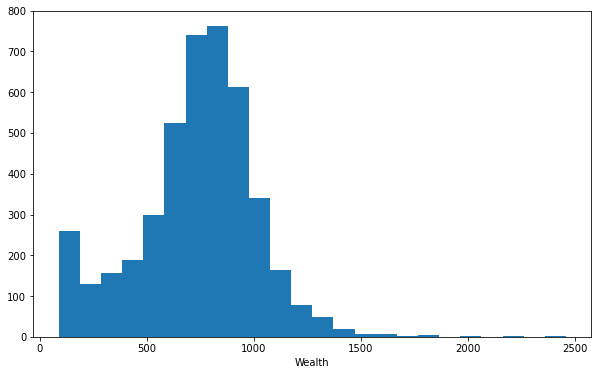

In [ ]:
wealth_distribution = nx.get_node_attributes(graph, attribute_wealth_name)
values = wealth_distribution.values()
bins_for_hist_wealth = 24

plt.figure(figsize=(10,6))
plt.hist(values, bins=bins_for_hist_wealth);
plt.xlabel("Wealth")

# Plot the wealth as a function of sigma (the saving predisposition) + a linear regression line 


<AxesSubplot:xlabel='sigma_p', ylabel='wealth'>

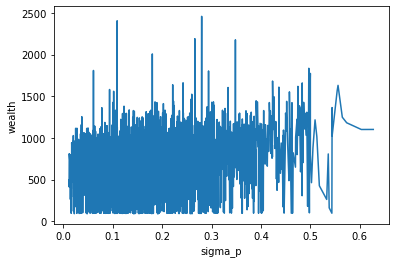

In [ ]:
sns.lineplot(x = "sigma_p", y = "wealth", data = df)

<AxesSubplot:xlabel='sigma_p', ylabel='wealth'>

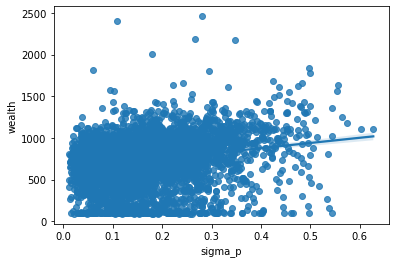

In [ ]:
sns.regplot(x="sigma_p", y="wealth", data = df)


# Plot the wealth as a function of beta (the business/risk predisposition) + a linear regression line

<AxesSubplot:xlabel='beta', ylabel='wealth'>

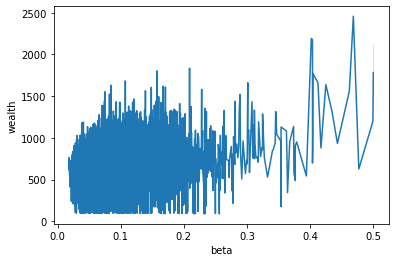

In [ ]:
sns.lineplot(x = "beta", y = "wealth", data = df)

<AxesSubplot:xlabel='beta', ylabel='wealth'>

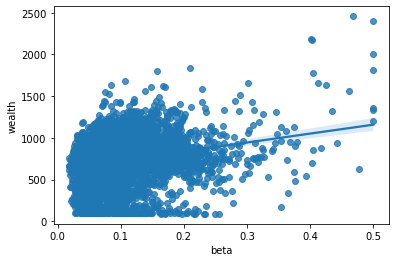

In [ ]:
sns.regplot(x="beta", y="wealth", data = df)


# Plot the wealth as a function of phi (the social predisposition) + a linear regression line 

<AxesSubplot:xlabel='phi', ylabel='wealth'>

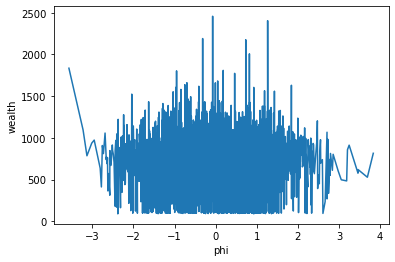

In [ ]:
sns.lineplot(x = "phi", y = "wealth", data = df)

<AxesSubplot:xlabel='phi', ylabel='wealth'>

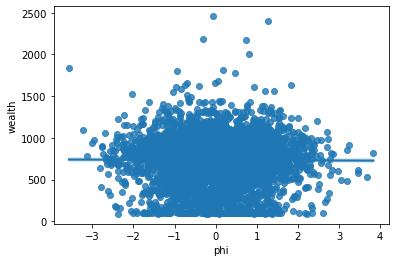

In [ ]:
sns.regplot(x="phi", y="wealth", data = df)


In [ ]:
### Code for statistics evaluation

index_of_statistics = "Statistics for time stamp " + str(t)

#mean wealth
mean_wealth = np.round(np.mean(df.wealth),3)

#median wealth
median_wealth = np.round(np.median(df.wealth),3)

# min(wealth), i.e., agent with the smallest wealth
node_with_smallest_wealth = df[df.wealth == df.wealth.min()].head(1)
node_with_smallest_wealth = np.round(node_with_smallest_wealth,3).add_suffix("_min_wealth").transpose()
node_with_smallest_wealth.rename(columns = {node_with_smallest_wealth.columns[0]:index_of_statistics}, inplace = True)

#max(wealth), i.e., the agent with the highest wealth
node_with_max_wealth = df[df.wealth == df.wealth.max()].head(1)
node_with_max_wealth = np.round(node_with_max_wealth,3).add_suffix("_max_wealth").transpose()
node_with_max_wealth.rename(columns = {node_with_max_wealth.columns[0]:index_of_statistics}, inplace = True)

#percent population below the poverty line (defining the poverty line as 35) 
population_below_povery_line = df[df.wealth < poverty_line].shape[0]
percent_population_below_poverty_line = np.round(population_below_povery_line/df.shape[0],3)

df_statistics = pd.DataFrame(data = [[mean_wealth, median_wealth, percent_population_below_poverty_line]],
                             columns = ["mean wealth", "median wealth", "Percent Population below poverty line"],
                             index=[index_of_statistics])

df_statistics = df_statistics.transpose()
df_statistics_new = pd.concat([df_statistics, node_with_smallest_wealth], axis = 0)
df_statistics_new = pd.concat([df_statistics_new, node_with_max_wealth], axis = 0)

df_statistics_new

,Statistics for time stamp 9999
mean wealth,734.570
median wealth,764.784
Percent Population below poverty line,0.000
node_index_min_wealth,31851.000
age_min_wealth,0.000
wealth_min_wealth,88.857
sigma_p_min_wealth,0.191
beta_min_wealth,0.256
phi_min_wealth,0.929
node_index_max_wealth,31145.000


In [ ]:
sns.set()

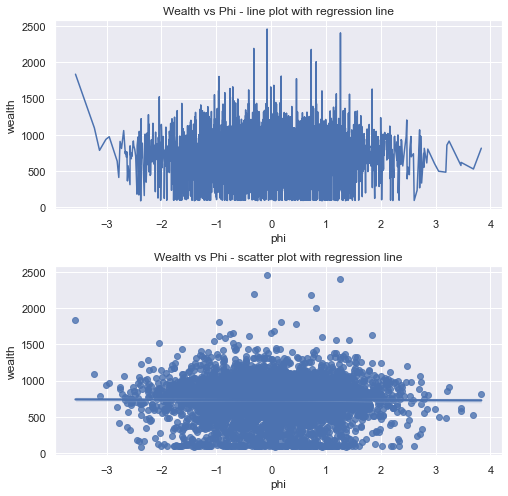

In [ ]:
fig, axs = plt.subplots(nrows=2, ncol=2, figsize=(8,8))
### Wealth vs phi
sns.lineplot(x = "phi", y = "wealth", data = df, ax=axs[0]).set(title='Wealth vs Phi - line plot with regression line')
sns.regplot(x="phi", y="wealth", data = df, ax=axs[1]).set(title='Wealth vs Phi - scatter plot with regression line')


plt.subplots_adjust(hspace = 0.3)

#sns.boxplot(x='education',y='wage', data=df_melt, ax=axs[2])

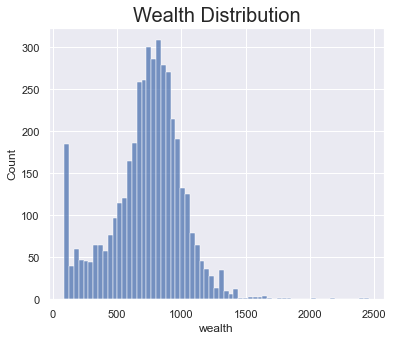

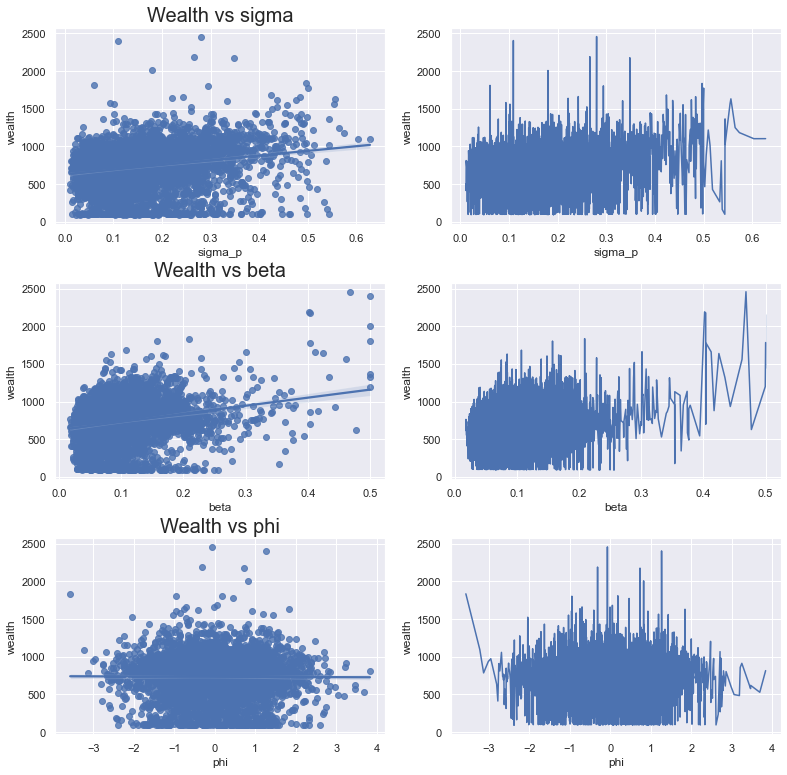

---------------------------------------- ********************************* ----------------------------------------


In [ ]:
#### plot wealth distribution
plt.figure(figsize=(6,5))
hist_sns = sns.histplot(data = df, x = "wealth")#.set(title='Wealth Distribution')
hist_sns.axes.set_title("Wealth Distribution",fontsize=20) # wealth distribution
############################################################################################

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(13,13))
### wealth vs sigma
regplot_wealth_sigma = sns.regplot(x="sigma_p", y="wealth", data = df, ax=axs[0,0]) #reg plot of wealth vs sigma
regplot_wealth_sigma.axes.set_title("Wealth vs sigma",fontsize=20)#line plot of wealth vs sigma

sns.lineplot(x = "sigma_p", y = "wealth", data = df, ax=axs[0,1])

### wealth vs beta
regplot_wealth_beta = sns.regplot(x="beta", y="wealth", data = df, ax=axs[1,0]) #reg plot of wealth vs beta
regplot_wealth_beta.axes.set_title("Wealth vs beta",fontsize=20)  #line plot of wealth vs beta

sns.lineplot(x = "beta", y = "wealth", data = df, ax=axs[1,1])

### Wealth vs phi
regplot_wealth_phi = sns.regplot(x="phi", y="wealth", data = df, ax=axs[2,0]) #.set(title='Wealth vs Phi - line plot with regression line')
regplot_wealth_phi.axes.set_title("Wealth vs phi",fontsize=20)  #line plot of wealth vs phi
sns.lineplot(x = "phi", y = "wealth", data = df, ax=axs[2,1]) #.set(title='Wealth vs Phi - scatter plot with regression line')

### space between each subplot
plt.subplots_adjust(hspace = 0.3)

plt.show()
print("---------------------------------------- ********************************* ----------------------------------------")




Text(0.5, 1.0, 'Wealth Distribution')

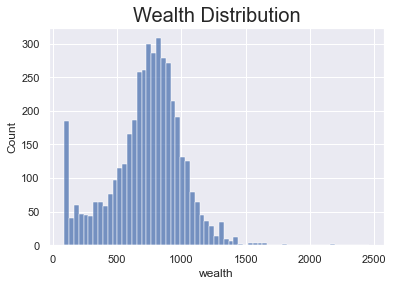

In [ ]:
hist_sns = sns.histplot(data = df, x = "wealth")#.set(title='Wealth Distribution')
hist_sns.axes.set_title("Wealth Distribution",fontsize=20)

In [ ]:
df

,node_index,age,wealth,sigma_p,beta,phi
0,27638,999,1067.922489,0.260336,0.038170,0.490165
1,27639,999,879.583041,0.189263,0.052408,-1.159997
2,27640,999,890.327786,0.076146,0.122399,0.851820
3,27641,999,1143.799709,0.287308,0.088738,0.513299
4,27642,999,1158.682524,0.409175,0.092254,-0.409652
...,...,...,...,...,...,...
4346,31984,0,98.449979,0.461570,0.169467,0.708951
4347,31985,0,99.353383,0.151772,0.105197,-0.739779
4348,31986,0,99.139118,0.118541,0.035927,0.644212
4349,31987,0,95.818138,0.108529,0.130887,-0.277461


AttributeError: 'AxesSubplot' object has no attribute 'lineplot'

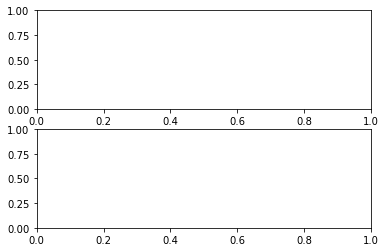

In [ ]:
fig, axs = plt.subplots(2)
axs[0].lineplot(x = "phi", y = "wealth", data = df)
axs[1].regplot(x="phi", y="wealth", data = df)

NameError: name 'axs' is not defined

0.0

In [ ]:
node_with_max_wealth = df[df.wealth == df.wealth.max()].head(1)
node_with_max_wealth

,0,age,wealth,sigma_p,beta,phi
0,2284,49,550.612053,0,0,0


In [ ]:
attribute_age_name = "age"
attribute_wealth_name = "wealth"
attribute_sigma_p_name = "sigma_p"
attribute_beta_name = "beta"
attribute_phi_name = "phi"

In [ ]:
df

,0,wealth
0,2284,550.612053
1,2285,550.612053
2,2286,550.612053
3,2287,550.612053
4,2288,550.612053
...,...,...
700,2984,100.000000
701,2985,100.000000
702,2986,100.000000
703,2987,100.000000


In [ ]:
pd.DataFrame(data = [[np.asarray(sigma_p_distribution.values()), np.asarray(sigma_p_distribution.values())]],
            columns = ["1", "2"])

,1,2
0,"dict_values([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","dict_values([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
pd.DataFrame.from_dict(graph.nodes.keys())

,0
0,28857
1,28858
2,28859
3,28860
4,28861
...,...
2942,31799
2943,31800
2944,31801
2945,31802


In [ ]:
nx.get_node_attributes(graph, [attribute_wealth_name, attribute_sigma_p_name])

In [ ]:
attribute_age_name = "age"
attribute_wealth_name = "wealth"
attribute_sigma_p_name = "sigma_p"
attribute_beta_name = "beta"
attribute_phi_name = "phi"

In [ ]:
payment[0]

0.0

In [ ]:
from sklearn.model_selection import train_test_split
#handling case of even/odd number of nodes
if len(graph.nodes)%2 == 0:
    train_size = int(len(graph.nodes)/2)
    test_size = train_size
else:
    train_size = int((len(graph.nodes)-1)/2)
    test_size = train_size
    
A_Payers ,B_receivers = train_test_split(np.asarray(graph.nodes),train_size=train_size, test_size = test_size, shuffle = True)

### sorting the two groups of nodes by the beta (decreasing)
A_Payers = sorted(A_Payers, key=lambda n: -graph.nodes[n]['beta'])
B_receivers = sorted(B_receivers, key=lambda n: -graph.nodes[n]['beta'])


#train_data = data[:50]
#test_data = data[50:]

In [ ]:
for payer_receiver_i in range(len(A_Payers)):
    A_payer_i = A_Payers[payer_receiver_i]
    B_receiver_i = B_receivers[payer_receiver_i]
    
    payer_wealth = graph.nodes[A_payer_i]["wealth"]
    payer_sigma = graph.nodes[A_payer_i]["sigma_p"]
    #beta
    payer_beta = graph.nodes[A_payer_i]["beta"]
    receiver_beta = graph.nodes[B_receiver_i]["beta"]
    mean_beta = (payer_beta  + receiver_beta)/2
    
    payment = payer_wealth * (1-payer_sigma) *(mean_beta*(max(np.random.beta(a=2, b=5, size=1),0.01)))
    
    if payer_wealth>=payment : #perform transaction as the payer has enough wealth for the transaction
        graph.nodes[A_payer_i]["wealth"] =  graph.nodes[A_payer_i]["wealth"] - payment
        graph.nodes[B_receiver_i]["wealth"] =  graph.nodes[B_receiver_i]["wealth"]  + payment
    
    #Perform transaction between payer i and receiver i
    

In [ ]:
graph.nodes[A_payer_i]["wealth"]

array([100.])

In [ ]:
A_payer_i = 1
B_receiver_i = 2
payer_wealth = graph.nodes[A_payer_i]["wealth"]
payer_sigma = graph.nodes[A_payer_i]["sigma_p"]
#beta
payer_beta = graph.nodes[A_payer_i]["beta"]
receiver_beta = graph.nodes[B_receiver_i]["beta"]
mean_beta = (payer_beta  + receiver_beta)/2

payment = payer_wealth * (1-payer_sigma) *(mean_beta*(max(np.random.beta(a=2, b=5, size=1),0.01)))

In [ ]:
payment

array([0.])

In [ ]:
len(A_Payers)

100

In [ ]:
if len(graph.nodes)%2 == 0:
    train_size = int(len(graph.nodes)/2)
    test_size = train_size
else:
    train_size = int((len(graph.nodes)-1)/2)
    test_size = train_size

In [ ]:
graph.nodes[1]["wealth"]

100

In [ ]:
num = 7
if num%2 == 0:
    print(num/2)
else:
    print((num-1)/2)

3.0


In [ ]:

payment = 𝑝𝑎𝑦𝑒𝑟_𝑤𝑒𝑎𝑙𝑡ℎ

array([ 76,  75, 103, 182,  96, 126, 124, 108, 165,  90, 191, 102,  30,
       113,  47, 200, 130, 147,  85, 141,  67, 183,  31, 115,   4, 187,
        32,  25,  98, 110,  10,  40, 107,  43,  18,  33, 132, 168, 177,
        49,  84, 100,  54,  80, 176, 145, 197, 160,  89, 167, 188, 150,
        52, 146, 149,  71,  77, 151,  64,  22, 104, 171, 192,  28, 131,
        17, 127,  12, 114,  78, 155, 109, 198, 134, 189,  61,  91,  86,
        19,  66,  51,  72, 173,  13,  88, 180, 159, 101, 118,  29,  20,
         0,  14, 116, 117,  42,  56, 152, 163,  92, 129])

In [ ]:
graph.nodes[122]["beta"] = 100
graph.nodes[83]["beta"] = 160
graph.nodes[94]["beta"] = 150
graph.nodes[194]["beta"] = 150

graph.nodes[76]["beta"] = 222
graph.nodes[113]["beta"] = 189

In [ ]:
sorted(graph.nodes(), key=lambda n: -graph.nodes[n]['beta'])


[76,
 113,
 83,
 94,
 194,
 122,
 0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 77,
 78,
 79,
 80,
 81,
 82,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,


In [ ]:
#payments are made by members of group A to members of group B,

In [ ]:
print(np.asarray(graph.nodes).shape)
print(x_train.shape)
print(x_test.shape)

(201,)
(100,)
(101,)


In [ ]:
np.asarray(graph.nodes)

array([3972, 3973, 3974, 3975, 3976, 3977, 3978, 3979, 3980, 3981, 3982,
       3983, 3984, 3985, 3986, 3987, 3988, 3989, 3990, 3991, 3992, 3993,
       3994, 3995, 3996, 3997, 3998, 3999, 4000, 4001, 4002, 4003, 4004,
       4005, 4006, 4007, 4008, 4009, 4010, 4011, 4012, 4013, 4014, 4015,
       4016, 4017, 4018, 4019, 4020, 4021, 4022, 4023, 4024, 4025, 4026,
       4027, 4028, 4029, 4030, 4031, 4032, 4033, 4034, 4035, 4036, 4037,
       4038, 4039, 4040, 4041, 4042, 4043, 4044, 4045, 4046, 4047, 4048,
       4049, 4050, 4051, 4052, 4053, 4054, 4055, 4056, 4057, 4058, 4059,
       4060, 4061, 4062, 4063, 4064, 4065, 4066, 4067, 4068, 4069, 4070,
       4071, 4072, 4073, 4074, 4075, 4076, 4077, 4078, 4079, 4080, 4081,
       4082, 4083, 4084, 4085, 4086, 4087, 4088, 4089, 4090, 4091, 4092,
       4093, 4094, 4095, 4096, 4097, 4098, 4099, 4100, 4101, 4102, 4103,
       4104, 4105, 4106, 4107, 4108, 4109, 4110, 4111, 4112, 4113, 4114,
       4115, 4116, 4117, 4118, 4119, 4120, 4121, 41

In [ ]:
random.shuffle(list(graph.nodes))

In [ ]:
huffle_nodes[0:]

TypeError: 'NoneType' object is not subscriptable

In [ ]:
#### transactions - here I stopeed!!!

for i in range(300):
    if (i+1)%3==1 and i!=0:
        print(i)


3
6
9
12
15
18
21
24
27
30
33
36
39
42
45
48
51
54
57
60
63
66
69
72
75
78
81
84
87
90
93
96
99
102
105
108
111
114
117
120
123
126
129
132
135
138
141
144
147
150
153
156
159
162
165
168
171
174
177
180
183
186
189
192
195
198
201
204
207
210
213
216
219
222
225
228
231
234
237
240
243
246
249
252
255
258
261
264
267
270
273
276
279
282
285
288
291
294
297


In [ ]:
simulation_length = 200
die_age = 20
nodes_f = 10000  #limiting factor on the total number of nodes
graph = ER_graph
attribute_age_name = "age"
attribute_wealth_name = "wealth"
attribute_sigma_p_name = "sigma_p"
attribute_beta_name = "beta"
attribute_phi_name = "phi"
ages_to_modify_connections = list(range(0, simulation_length+1, 500))[1:]

verbose_check=  True
treasury = 0
last_node_index = max(list(graph.nodes))  #store the last index of the node in the graph - for creating mpre nodes later

for t in range(simulation_length):
    N_t = int(n + (nodes_f - n)*((1)/(1+math.exp(-((t/3500)-1)))))
    need_to_add_nodes = N_t - len(graph.nodes)
    print(N_t)
    print("need_to_add_nodes: ", need_to_add_nodes)
    print()

2835
need_to_add_nodes:  2635

2836
need_to_add_nodes:  2636

2836
need_to_add_nodes:  2636

2837
need_to_add_nodes:  2637

2837
need_to_add_nodes:  2637

2838
need_to_add_nodes:  2638

2838
need_to_add_nodes:  2638

2839
need_to_add_nodes:  2639

2840
need_to_add_nodes:  2640

2840
need_to_add_nodes:  2640

2841
need_to_add_nodes:  2641

2841
need_to_add_nodes:  2641

2842
need_to_add_nodes:  2642

2842
need_to_add_nodes:  2642

2843
need_to_add_nodes:  2643

2843
need_to_add_nodes:  2643

2844
need_to_add_nodes:  2644

2844
need_to_add_nodes:  2644

2845
need_to_add_nodes:  2645

2846
need_to_add_nodes:  2646

2846
need_to_add_nodes:  2646

2847
need_to_add_nodes:  2647

2847
need_to_add_nodes:  2647

2848
need_to_add_nodes:  2648

2848
need_to_add_nodes:  2648

2849
need_to_add_nodes:  2649

2849
need_to_add_nodes:  2649

2850
need_to_add_nodes:  2650

2851
need_to_add_nodes:  2651

2851
need_to_add_nodes:  2651

2852
need_to_add_nodes:  2652

2852
need_to_add_nodes:  2652

2853
nee

In [ ]:
ages_to_modify_connections

[]

In [ ]:
### edges adjustments
for node in graph.nodes:
    if graph.nodes[node][attribute_age_name] in ages_to_modify_connections : #if age is 500, 1000,1500, etc
        formula_for_edges = int(np.round(np.random.normal(loc = graph.nodes[node][attribute_phi_name]),0))
        if formula_for_edges < 0 : #then randomly remove edges
            nodes_neighbors = [n for n in graph.neighbors(node)]
            numer_of_edges_to_remove = np.abs(formula_for_edges) #k
            ### now we need to randomly select K EDGES TO REMOVE, K = |formula_for_edges|
            if numer_of_edges_to_remove > len(nodes_neighbors):
                numer_of_edges_to_remove = nodes_neighbors #if you are asked to remove more edges than the amount of existing edgesm than just remove all of them
            remove_edges_from_the_following_nodes = random.sample(nodes_neighbors, numer_of_edges_to_remove)
            ### removing the edges:
            for edge_to_remove in remove_edges_from_the_following_nodes:
                graph.remove_edge(node, edge_to_remove)
        else: #then add edges
            nodes_neighbors = [n for n in graph.neighbors(node)]
            numer_of_edges_to_add = formula_for_edges #k
            ### now we need to randomly select K EDGES TO add from the ones that are not already connected, K = |formula_for_edges|
            not_1st_relatives_nodes = list(set(graph.nodes) - set(nodes_neighbors))
            add_edges_from_the_following_nodes = random.sample(not_1st_relatives_nodes, numer_of_edges_to_add)

            for edge_to_add in add_edges_from_the_following_nodes:
                graph.add_edge(node, edge_to_add)

In [ ]:
list_nodes_roy = [1,2,3,4,5,6,7,8,9,10]
ER_graph.nodes[2]["age"] = 499
ER_graph.nodes[4]["age"] = 500
ER_graph.nodes[7]["age"] = 1001
ER_graph.nodes[9]["age"] = 1000
ER_graph.nodes[1]["age"] = 999

ages_to_modify_connections = list(range(0, simulation_length+1, 500))[1:]

for node in list_nodes_roy:
    if graph.nodes[node][attribute_age_name] in ages_to_modify_connections :
        print(node)
        print(graph.nodes[node])


In [ ]:
simulation_length = 50000


In [ ]:
numer_of_edges_to_remove

1

In [ ]:
#random.sample(nodes_neighbors, 35)

In [ ]:
len(nodes_neighbors)

28

In [ ]:
len(graph.edges)

19900

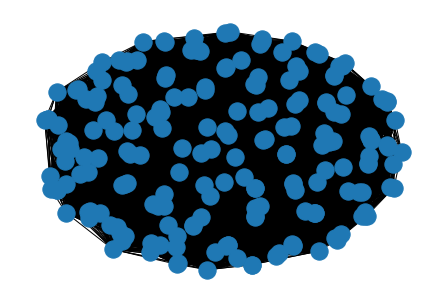

In [ ]:
nx.draw(graph)

In [ ]:
treasury

1000.0000000000001

In [ ]:
ER_graph.nodes[node_to_remove]["wealth"]/neighbors_of_node_i_that_die


100

In [ ]:
ER_graph.nodes[2]["wealth"] = ER_graph.nodes[2]["wealth"] + 50

In [ ]:
ER_graph.nodes[2]["wealth"] 

150

In [ ]:
nx.set_node_attributes(ER_graph, values = 0, name="age")
update_node_age(graph = ER_graph, attribute_name = attribute_age_name)



In [ ]:
ER_graph.nodes[3]


{'age': 3}

In [ ]:
print(ER_graph.nodes[1])

{'age': 3}


In [ ]:
updated_dict

{0: 1,
 1: 1,
 2: 1,
 3: 1,
 4: 1,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 1,
 10: 1,
 11: 1,
 12: 1,
 13: 1,
 14: 1,
 15: 1,
 16: 1,
 17: 1,
 18: 1,
 19: 1,
 20: 1,
 21: 1,
 22: 1,
 23: 1,
 24: 1,
 25: 1,
 26: 1,
 27: 1,
 28: 1,
 29: 1,
 30: 1,
 31: 1,
 32: 1,
 33: 1,
 34: 1,
 35: 1,
 36: 1,
 37: 1,
 38: 1,
 39: 1,
 40: 1,
 41: 1,
 42: 1,
 43: 1,
 44: 1,
 45: 1,
 46: 1,
 47: 1,
 48: 1,
 49: 1,
 50: 1,
 51: 1,
 52: 1,
 53: 1,
 54: 1,
 55: 1,
 56: 1,
 57: 1,
 58: 1,
 59: 1,
 60: 1,
 61: 1,
 62: 1,
 63: 1,
 64: 1,
 65: 1,
 66: 1,
 67: 1,
 68: 1,
 69: 1,
 70: 1,
 71: 1,
 72: 1,
 73: 1,
 74: 1,
 75: 1,
 76: 1,
 77: 1,
 78: 1,
 79: 1,
 80: 1,
 81: 1,
 82: 1,
 83: 1,
 84: 1,
 85: 1,
 86: 1,
 87: 1,
 88: 1,
 89: 1,
 90: 1,
 91: 1,
 92: 1,
 93: 1,
 94: 1,
 95: 1,
 96: 1,
 97: 1,
 98: 1,
 99: 1,
 100: 1,
 101: 1,
 102: 1,
 103: 1,
 104: 1,
 105: 1,
 106: 1,
 107: 1,
 108: 1,
 109: 1,
 110: 1,
 111: 1,
 112: 1,
 113: 1,
 114: 1,
 115: 1,
 116: 1,
 117: 1,
 118: 1,
 119: 1,
 120: 1,
 121: 1,
 122: 1,
 12

In [ ]:
ER_graph.nodes[1]

{'age': 0}

In [ ]:
age_dict = dict.fromkeys(ER_graph.nodes(),0)
age_dict.values

TypeError: unsupported operand type(s) for +: 'dict' and 'int'

In [ ]:
updated_dict = dict()
for node, age_value in age_dict.items():
    updated_dict[node] = age_value + 1

In [ ]:
updated_dict

{0: 1,
 1: 1,
 2: 1,
 3: 1,
 4: 1,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 1,
 10: 1,
 11: 1,
 12: 1,
 13: 1,
 14: 1,
 15: 1,
 16: 1,
 17: 1,
 18: 1,
 19: 1,
 20: 1,
 21: 1,
 22: 1,
 23: 1,
 24: 1,
 25: 1,
 26: 1,
 27: 1,
 28: 1,
 29: 1,
 30: 1,
 31: 1,
 32: 1,
 33: 1,
 34: 1,
 35: 1,
 36: 1,
 37: 1,
 38: 1,
 39: 1,
 40: 1,
 41: 1,
 42: 1,
 43: 1,
 44: 1,
 45: 1,
 46: 1,
 47: 1,
 48: 1,
 49: 1,
 50: 1,
 51: 1,
 52: 1,
 53: 1,
 54: 1,
 55: 1,
 56: 1,
 57: 1,
 58: 1,
 59: 1,
 60: 1,
 61: 1,
 62: 1,
 63: 1,
 64: 1,
 65: 1,
 66: 1,
 67: 1,
 68: 1,
 69: 1,
 70: 1,
 71: 1,
 72: 1,
 73: 1,
 74: 1,
 75: 1,
 76: 1,
 77: 1,
 78: 1,
 79: 1,
 80: 1,
 81: 1,
 82: 1,
 83: 1,
 84: 1,
 85: 1,
 86: 1,
 87: 1,
 88: 1,
 89: 1,
 90: 1,
 91: 1,
 92: 1,
 93: 1,
 94: 1,
 95: 1,
 96: 1,
 97: 1,
 98: 1,
 99: 1,
 100: 1,
 101: 1,
 102: 1,
 103: 1,
 104: 1,
 105: 1,
 106: 1,
 107: 1,
 108: 1,
 109: 1,
 110: 1,
 111: 1,
 112: 1,
 113: 1,
 114: 1,
 115: 1,
 116: 1,
 117: 1,
 118: 1,
 119: 1,
 120: 1,
 121: 1,
 122: 1,
 12